# OdC's 2025 NDVI Geovisor

This notebook loads each city's NDVI data, processes and __creates the .htmls needed for kepler visualization.__

* __Important note: Worked fine with keplergl v0.3.2, but not with kepler v.0.3.7.__
* __Final parameters used for NDVI Visor:__
  * __res__: 10
  * __filter_urban__: True
  * __dissolve_hexs__: False
  * __calculate_slope__: False
  * __palette__: palette_2025
  * __stroke__: 0.05, white
  * __opacity__: 0.10

In [1]:
# NDVI 2023 OdC's publication (White background)
# Suelo artificial: "#c6c6c6" (Light grey)
# Suelo: "#edf0d8" (Cream)
# Vegetación mínima: "#add767" (Light green)
# Vegetación moderada: "#1c934f" (Green)
# Vegetación máxima: "#004428" (Dark green)

# OdC's 2025 NDVI Geovisor (Altered in order to work with both dark basemap and satellite basemap)
# Suelo artificial: "#939393" (Semi-dark gray)
# Vegetación escasa: "#e9f6d0" (Very light green)
# Vegetación moderada: "#add767" (Light green)
# Vegetación densa: "#1c934f" (Green)
# Vegetación muy densa: "#004428" (Dark green)

## Import libraries

In [2]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [3]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

# Imports que venían en el Notebook 15-min-city > 13-15-min-kepler-test.ipynb
import io
#import boto3
from keplergl import KeplerGl

# Add slope visualization as a new layer to be visualized in the config dict [Canceled]
import copy

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Config notebook

In [11]:
test = True
if test == True:
    city_lst = ['Aguascalientes'] # Gets overwritten if test = False
    res = 8
else:
    res = 10

projected_crs = 'EPSG:6372'
# Processing - Filter for urban areas only?
filter_urban = True
# Processing - If running CDMX (capital city), add ZMVM (metropolitan area)
merge_capital = True
# Output - Dissolve hexs by NDVI Category?
dissolve_hexs = False #If true, cannot add ndvi slope data
# Output - Add slope data? (Only works if dissolve_hexs is false)
slope_data = False

# Directory where .html files are saved
map_output_dir = str(project_root) + f"/data/processed/visor_ndvi/"

In [5]:
# Slope function
def calc_slope(row, cols):
    data = row[cols].astype(float).values
    slope, intercept = np.polyfit(years, data, 1)
    return slope

## Find all available cities (If test = False, rewrites city_list)

In [6]:
if test == False:
    # Find all available cities
    ndvi_schema = 'raster_analysis'
    ndvi_table = 'ndvi_analysis_hex'
    scan_res = 8
    query = f"SELECT city FROM {ndvi_schema}.{ndvi_table} WHERE \"res\" = '{scan_res}\'"
    ndvi_df = aup.df_from_query(query)
    city_lst = list(ndvi_df.city.unique())

# If merge_capital, drop ZMVM in order to load ZMVM when loading CDMX during processing.
if merge_capital and ('CDMX' in city_lst) and ('ZMVM' in city_lst):
    city_lst.remove('ZMVM')

print(f"{len(city_lst)} cities to run at res {res}.")
city_lst

1 cities to run at res 10.


['CDMX']

## Create Kepler HTMLs files by city

In [10]:
i=0
for city in city_lst:

    try:
        print("--"*30)
        print(f"--- STARTING CITY {i}/{len(city_lst)}: {city}.")
    
        # 1.0 --- --- --- LOAD DATA --- --- ---
        
        # 1.1 --- LOAD URBAN HEXS
        print(f"Loading {city}'s urban hexs.")
        # Load data
        hex_schema = 'hexgrid'
        hex_table = f'hexgrid_{res}_city_2020'
        # Load city's hexs filtering for urban areas if required
        if filter_urban:
            hex_type = 'urban'
            query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\' AND \"type\" = '{hex_type}\'"
        else:
            query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\'"
        hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
        
        # SPECIFIC CASE - Merge capital's hexs (CDMX + ZMVM)
        if merge_capital and (city == 'CDMX'):
            print("MERGING CDMX + ZMVM hexs.")
            # Load ZMVM's hexs filtering for urban areas if required
            if filter_urban:
                hex_type = 'urban'
                query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = 'ZMVM\' AND \"type\" = '{hex_type}\'"
            else:
                query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = 'ZMVM\'"
            metro_hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
            # Merge CDMX and ZMVM hexs
            hex_gdf = pd.concat([hex_gdf,metro_hex_gdf])
            
        # Read and format cols
        hex_gdf['res'] = res
        hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
        hex_gdf.to_crs(projected_crs,inplace=True)
        # List all unique hex_ids
        hexid_lst = list(hex_gdf.hex_id.unique())
        del hex_gdf
        
        # 1.2 --- LOAD NDVI DATA
        print(f"Loading {city}'s NDVI data.")
        ndvi_schema = 'raster_analysis'
        ndvi_table = 'ndvi_analysis_hex'
        query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
        ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

        # SPECIFIC CASE - Merge capital's NDVI (CDMX + ZMVM)
        if merge_capital and (city == 'CDMX'):
            print("MERGING CDMX + ZMVM NDVI.")
            # Load metro area's NDVI
            query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = 'ZMVM\' AND \"res\" = '{res}\'"
            metro_ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
            # Merge capital and metro area hexs
            ndvi_gdf = pd.concat([ndvi_gdf,metro_ndvi_gdf])
            # Drop duplicated hexs (Both in CDMX and ZMVM)
            ndvi_gdf.drop_duplicates(subset="hex_id", 
                                     inplace=True)
    
        ndvi_gdf.to_crs(projected_crs,inplace=True)
        # Filter for urban areas if required
        if filter_urban:
            ndvi_gdf = ndvi_gdf.loc[ndvi_gdf.hex_id.isin(hexid_lst)].copy()
        # Inf values check
        infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
        if len(infs)>0:
            print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
            ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()
        
        # 2.0 --- --- --- CALCULATIONS AND DATA TREATMENT --- --- ---
        # If dissolve_hexs, dissolves hexs by NDVI categories and does not calculate slope.
        # If not dissolve_hexs, can add slope.

        # 2.1 --- CALCULATE NDVI CATEGORIES
        print(f"Creating {city}'s vegetation categories and preparing hex_kepler.")
        ndvi_categories = ['5. Suelo artificial/agua', '4. Vegetación escasa', '3. Vegetación moderada', '2. Vegetación densa', '1. Vegetación muy densa']
        #original_ndvi_categories = ['Suelo artificial/Agua/Piedra','Suelo','Mínima densidad vegetal,'Moderada densidad vegetal','Alta densidad vegetal']
        
        # Create vegetation categories
        ndvi_gdf['ndvi_median_rango'] = np.nan
        ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = ndvi_categories[4]
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
                     (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = ndvi_categories[3]
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
                     (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = ndvi_categories[2]
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
                     (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = ndvi_categories[1]
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = ndvi_categories[0]
        # Define order and convert col into ordered category
        ndvi_gdf['ndvi_median_rango'] = pd.Categorical(ndvi_gdf['ndvi_median_rango'], categories=ndvi_categories, ordered=True)
        
        if dissolve_hexs:
            print(f"Processing option A: Dissolving {city}'s NDVI by categories, not adding slope.")
            # --- --- ---  Dissolve ndvi_gdf by ndvi category
            ndvi_diss = ndvi_gdf.dissolve(by='ndvi_median_rango')
            ndvi_diss.reset_index(inplace=True)
            
            # --- --- --- hex_kepler formating
            # Rename columns of interest
            main_col = 'Rango de vegetación'
            rename_columns = {'ndvi_median_rango':main_col}
            hex_kepler = ndvi_diss.copy()
            hex_kepler.rename(columns=rename_columns,inplace=True)
            # Keep columns of interest and geometry
            hex_kepler = hex_kepler[[main_col,'geometry']]            
            
        else:
            if slope_data:
                print(f"Processing option B: Not dissolving {city}'s NDVI, includes NDVI slope.")
                # --- --- --- Calculate slopes
                years = np.array([2018, 2019, 2020, 2021, 2022, 2023])
                ndvi_columns = [f'ndvi_{year}' for year in years]
                ndvi_gdf['ndvi_slope'] = ndvi_gdf.apply(calc_slope, args=(ndvi_columns,), axis=1)
                
                # --- --- --- hex_kepler formating
                # Rename columns of interest
                main_col = 'Rango de vegetación'
                slope_col = 'Cambio 2018 a 2023'
                rename_columns = {'ndvi_median_rango':main_col,
                                  'ndvi_slope':slope_col}
                hex_kepler = ndvi_gdf.copy()
                hex_kepler.rename(columns=rename_columns,inplace=True)
                # Keep columns of interest and geometry
                hex_kepler = hex_kepler[[main_col,slope_col,'geometry']]
                
            else:
                print(f"Processing option C: Not dissolving {city}'s NDVI, nor including NDVI slope.")
                # --- --- --- hex_kepler formating
                # Rename columns of interest
                main_col = 'Rango de vegetación'
                rename_columns = {'ndvi_median_rango':main_col}
                hex_kepler = ndvi_gdf.copy()
                hex_kepler.rename(columns=rename_columns,inplace=True)
                # Keep columns of interest and geometry
                hex_kepler = hex_kepler[[main_col,'geometry']]
        
        # 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
        # PREPARE HEX KEPLER - Append dummy rows to gdf (They don't show since nothing is assigned to 'geometry' col,
        # but ensures that all categories are present in each city (And therefore, the simbology doesn't vary from city to city)
        if slope_data:
            print(f"hex_kepler option B: Considering slope in html creation.")
            dummy_rows = pd.DataFrame({main_col: ndvi_categories,
                                       slope_col: [None]*5})
        else:
            print(f"hex_kepler option A or C: Not considering slope in html creation.")
            dummy_rows = pd.DataFrame({main_col: ndvi_categories})
        dummy_gdf = gpd.GeoDataFrame(dummy_rows, geometry=[None]*5, crs=hex_kepler.crs)
        # PREPARE HEX KEPLER - Turn main_col into categorical ordered column in order to keep categorical order after concatenation
        dummy_gdf[main_col] = pd.Categorical(dummy_gdf[main_col], categories=ndvi_categories, ordered=True)
        hex_kepler_complete = pd.concat([hex_kepler, dummy_gdf], ignore_index=True)
        # PREPARE HEX KEPLER - Force categorical order
        hex_kepler_complete.sort_values(by=main_col, inplace=True)        
        # PREPARE HEX KEPLER - Kepler not loading if it is projected_crs
        if hex_kepler_complete.crs != "EPSG:4326":
            hex_kepler_complete.to_crs("EPSG:4326",inplace=True)
            print(f"Changed {city}'s hex_kepler_complete crs to EPSG:4326.")
        
        # CREATE CONFIGURATION
        print(f"Starting {city}'s map config.")
        config, config_idx = aup.kepler_config()
        
        # LAYER CONFIGURATION - Set layer to be visualized on map
        config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"]["name"] = main_col
        
        # PALETTE CONFIGURATION - Set the color palette of the visualized layer
        # BRBG color palette divided in 5 categories (Vegetation). Browns for lower values, Greens for higher values.
        brbg_5 = ["#01665E", #Dark green-blueish
                  "#35978F", #Light green-blueish
                  "#DFE6E1", #Light gray
                  "#BF812D", #Light brown
                  "#8C510A"] #Dark brown
        # Color palette from gray to cream to green, used in 2023 on a white background
        palette_2023 = ["#004428", # Dark green
                        "#1c934f", # Green
                        "#add767", # Light green
                        "#edf0d8", # Cream
                        "#c6c6c6"] # Gray
        # Color palette with one grey and 4 greens, used here for black and satellite backgrounds
        palette_2025 = ["#004428", # Dark green
                        "#1c934f", # Green
                        "#add767", # Light green
                        "#e9f6d0", # Very light green
                        "#939393"] # Medium gray        
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["colorRange"] = {"name": "BrBG_custom",
                                                                                          "type": "custom",
                                                                                          "category": "Custom",
                                                                                          "colors": palette_2025,
                                                                                          "reversed": False}
        
        # STROKE CONFIGURATION - Set stroke width and color [Final decision: 0.05 white]
        # Black --> "#000000" --> [0, 0, 0]
        # White --> "#ffffff" --> [255, 255, 255]
        stroke=0.05
        strokecolor = [255, 255, 255]
        if dissolve_hexs: #No stroke when dissolving hex because when hovering, a lot of lines get highlighted.
            stroke=0
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["thickness"] = stroke #aup.kepler_config() value: 0.5
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["strokeColor"] = strokecolor #aup.kepler_config() value: [28, 27, 27]

        
        # OPACITY CONFIGURATION - Set object's opacity [Final decision: 0.10]
        fillopacity = 0.10
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["opacity"] = fillopacity #aup.kepler_config() value: 0.85
        
        # FUNCTIONALITIES CONFIGURATION - Turning on/off map functionalities
        # Turn on geocoder (Search tab)
        config["config"]["visState"]["interactionConfig"]["geocoder"]["enabled"] = True
        # Stop user from activating manually dual map viewer
        config["config"]["splitMaps"] = []
        # Force turn on legend
        config["config"]["visState"]["legend"] = {"active": True}
        # FUNCTIONALITIES CONFIGURATIONS ALREADY TURNED OFF IN FUNCTION (Written here as reminder)
        # Turn off dual map viewer #aup.kepler_config() value:False
        #config["config"]["mapState"]["isSplit"] = False
        # Turn off brush #aup.kepler_config() value:False
        #config["config"]["visState"]["interactionConfig"]["brush"]["enabled"] = False
        # Turn off coordinate #aup.kepler_config() value:False
        #config["config"]["visState"]["interactionConfig"]["coordinate"]["enabled"] = False
        
        # STARTING POINT CONFIGURATION - Set map's starting point for each city
        longitude = hex_kepler_complete.dissolve().geometry.centroid.x
        latitude = hex_kepler_complete.dissolve().geometry.centroid.y
        config["config"]["mapState"]["latitude"] = latitude[0]
        config["config"]["mapState"]["longitude"] = longitude[0]
        
        # HOVERING CONFIGURATION - Set data to show when hovering over hex
        if slope_data:
            # Option A: Shows both values in one layer:
            #config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"]["Análisis de hexágono"] = [main_col,slope_col]
            # Option B: Shows NDVI category in NDVI category layer and Slope in Slope layer.
            config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {
                "Análisis de hexágono": [main_col],
                "Análisis de pendiente": [slope_col]
            }
        else:
            config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {"Análisis de hexágono": [main_col]}  
        
        # END OF CONFIGURATION - Add configuration and data to html file
        map_city = KeplerGl(height=800)
        map_city.config = config
        if slope_data:
            map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')
            map_city.add_data(hex_kepler_complete, name='Análisis de pendiente')
        else:
            map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')
        
        print(f"Finished {city}'s map config.")
        
        # 4.0 --- --- --- SAVE HTML --- --- ---
        if test == True:
            file_name = f'TestNDVI_{city}_{res}_op{fillopacity}_strk{stroke}_palette2025.html'
            map_city.save_to_html(file_name = map_output_dir+f"tests/{file_name}", read_only=False)
        else:
            # SPECIFIC CASE - Merge capital's NDVI (CDMX + ZMVM)
            if merge_capital and (city == 'CDMX'):
                file_name = f'VisorNDVI_{city}-ZMVM_res{res}.html'
            else:
                file_name = f'VisorNDVI_{city}_res{res}.html'
            map_city.save_to_html(file_name = map_output_dir+f"{file_name}", read_only=False)
            print(f"Saved {city}'s map config html file.")
            
    except:
        print("--"*30)
        print(f"ERROR: {city}.")
        print("--"*30)

    i+=1

------------------------------------------------------------
--- STARTING CITY 0/1: CDMX.
Loading CDMX's urban hexs.
MERGING CDMX + ZMVM hexs.
Loading CDMX's NDVI data.
MERGING CDMX + ZMVM NDVI.
Creating CDMX's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving CDMX's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed CDMX's hex_kepler_complete crs to EPSG:4326.
Starting CDMX's map config.


/tmp/ipykernel_55225/603222898.py:224: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_55225/603222898.py:225: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Finished CDMX's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/tests/TestNDVI_CDMX_10_opacity0.1_whitestroke0.05_altered_7.html!


## __Keplerg TESTS (Spanglish)__

In [7]:
print(hex_kepler["Rango de vegetación"].unique())
print(hex_kepler.crs)
print(hex_kepler.shape)
hex_kepler.head(5)

['Suelo artificial', 'Suelo', 'Mínima vegetación', 'Moderada vegetación', 'Alta vegetación']
Categories (5, object): ['Suelo artificial' < 'Suelo' < 'Mínima vegetación' < 'Moderada vegetación' < 'Alta vegetación']
EPSG:6372
(58103, 2)


,Rango de vegetación,geometry
275,Suelo artificial,"POLYGON ((2680387.634 1510279.740, 2680454.828..."
276,Suelo,"POLYGON ((2680306.274 1510396.589, 2680373.469..."
277,Suelo,"POLYGON ((2680529.104 1510291.736, 2680596.298..."
278,Mínima vegetación,"POLYGON ((2680447.746 1510408.584, 2680514.940..."
279,Suelo,"POLYGON ((2680327.521 1510150.896, 2680394.716..."


<Axes: >

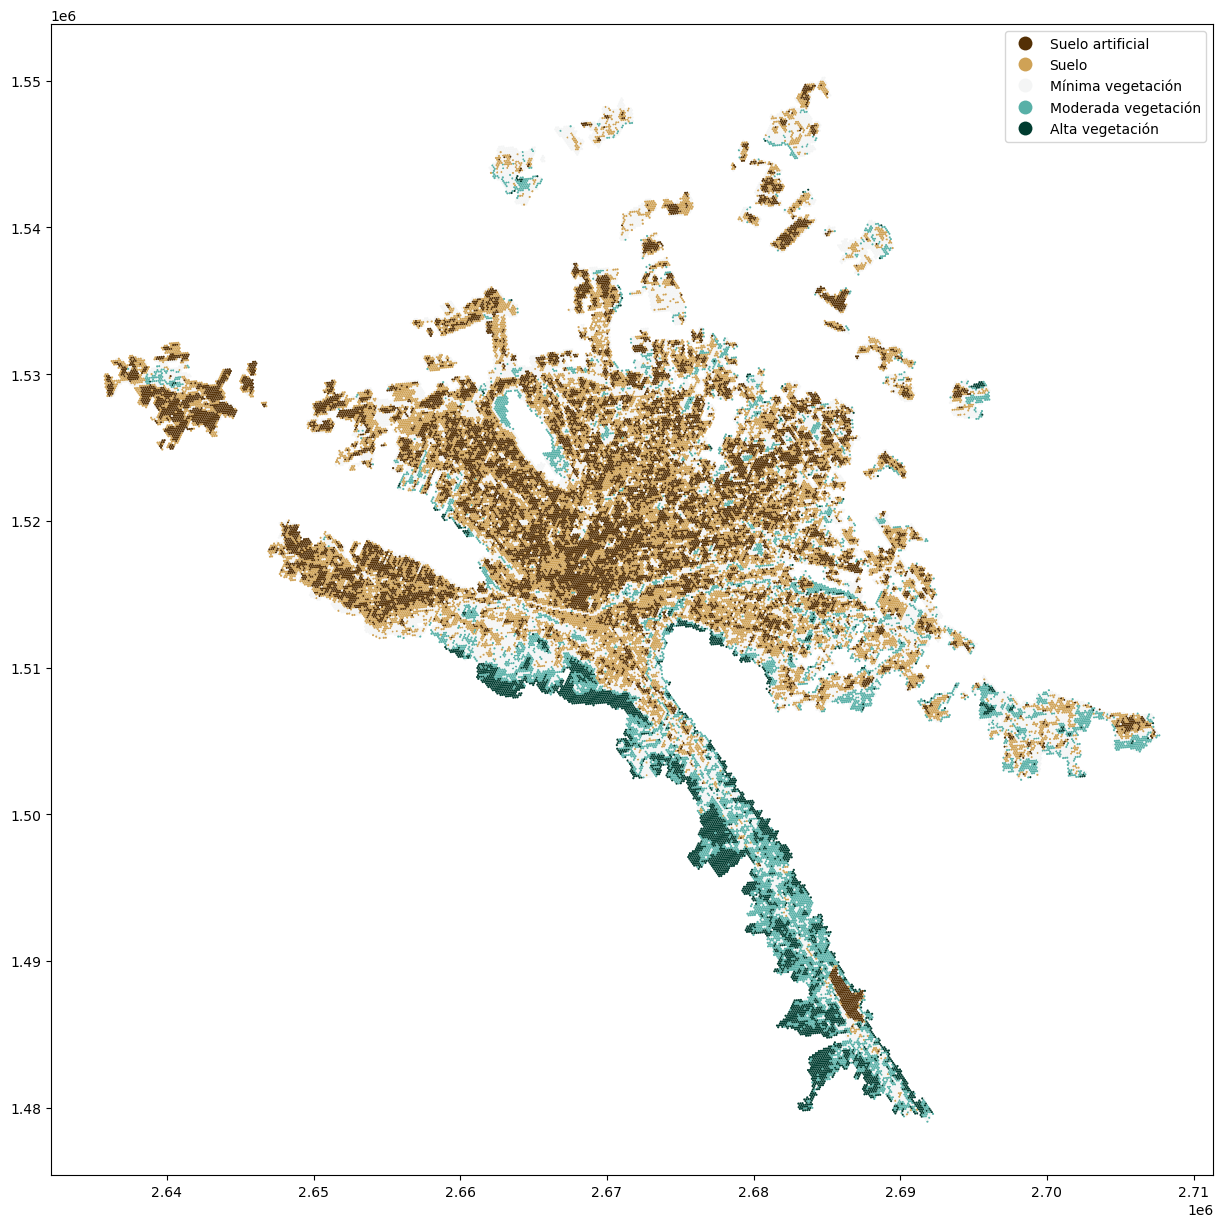

In [8]:
fig,ax = plt.subplots(figsize=(15,15))
hex_kepler.plot('Rango de vegetación',
                cmap='BrBG',
                legend=True,
                ax=ax)

### Prueba kepler en limpio [Versión más avanzada]

In [10]:
# 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
# Append dummy rows to gdf (They don't show since nothing is assigned to 'geometry' col,
# but ensures that all categories are present in each city (And therefore, the simbology doesn't vary from city to city)
if slope_data:
    dummy_rows = pd.DataFrame({main_col: categories,
                               slope_col: [None]*5})
else:
    dummy_rows = pd.DataFrame({main_col: categories})

dummy_gdf = gpd.GeoDataFrame(dummy_rows, geometry=[None]*5, crs=hex_kepler.crs)
# Turn main_col into categorical ordered column in order to keep categorical order after concatenation
dummy_gdf[main_col] = pd.Categorical(dummy_gdf[main_col], categories=categories, ordered=True)
hex_kepler_complete = pd.concat([hex_kepler, dummy_gdf], ignore_index=True)
# Force categorical order
hex_kepler_complete.sort_values(by=main_col, inplace=True)
# Categorical revision
print("CATEGORICAL REVISION:")
print(hex_kepler_complete[main_col].cat.categories)
print(hex_kepler_complete[main_col].unique())

# Kepler not loading if it is projected_crs
if hex_kepler_complete.crs != "EPSG:4326":
    hex_kepler_complete.to_crs("EPSG:4326",inplace=True)
    print(f"Changed {city}'s hex_kepler_complete crs to EPSG:4326.")

# CONFIGURATION
config, config_idx = aup.kepler_config()
# CONFIGURATION - Configure visualized layer
config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"]["name"] = main_col

# CONFIGURATION - Configure the color palette of the visualized layer
# BRBG color palette divided in 5 categories (Vegetation). Browns for lower values, Greens for higher values.
brbg_5 = ["#01665E", #Dark green-blueish
          "#35978F", #Light green-blueish
          "#DFE6E1", #Light gray
          "#BF812D", #Light brown
          "#8C510A"] #Dark brown

# Color palette from gray to green, used in 2023
palette_2023 = ["#004428", # Dark green
                "#1c934f", # Green
                "#add767", # Light green
                "#edf0d8", # Cream
                "#c6c6c6"] # Gray

config["config"]["visState"]["layers"][0]["config"]["visConfig"]["colorRange"] = {
    "name": "BrBG_custom",
    "type": "custom",
    "category": "Custom",
    "colors": palette_2023,
    "reversed": False
}
# CONFIGURATION - Stroke width and color [Final decision: 0.05 white]
stroke=0.05
if dissolve_hexs: #No stroke when dissolving hex because when hovering, a lot of lines get highlighted.
    stroke=0

config["config"]["visState"]["layers"][0]["config"]["visConfig"]["thickness"] = stroke # En el dict. está en 0.5
config["config"]["visState"]["layers"][0]["config"]["visConfig"]["strokeColor"] = [255, 255, 255] # En el dict. está [28, 27, 27]
# Negro --> "#000000" --> [0, 0, 0]
# Blanco --> "#ffffff" --> [255, 255, 255]

# CONFIGURATION - Opacity
opacity = 0.10 # Set 0.10
config["config"]["visState"]["layers"][0]["config"]["visConfig"]["opacity"] = opacity # En la función está en 0.85

# CONFIGURATION - Turning on/off map functionalities
# Turn on geocoder (Search tab)
config["config"]["visState"]["interactionConfig"]["geocoder"]["enabled"] = True
# Stop user from activating manually dual map viewer
config["config"]["splitMaps"] = []
# Force turn on legend
config["config"]["visState"]["legend"] = {"active": True}

# CONFIGURATIONS ALREADY TURNED OFF IN FUNCTION
# Turn off dual map viewer (Already turned off in function)
#config["config"]["mapState"]["isSplit"] = False
# Turn off brush (Already turned off in function)
#config["config"]["visState"]["interactionConfig"]["brush"]["enabled"] = False
# Turn off coordinate (Already turned off in function)
#config["config"]["visState"]["interactionConfig"]["coordinate"]["enabled"] = False

# CONFIGURATION - Configure map starting point
longitude = hex_kepler_complete.dissolve().geometry.centroid.x
latitude = hex_kepler_complete.dissolve().geometry.centroid.y
config["config"]["mapState"]["latitude"] = latitude[0]
config["config"]["mapState"]["longitude"] = longitude[0]

# CONFIGURATION - Configure data when hovering over hex
# Just one layer
#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"]["Análisis de hexágono"] = [main_col,slope_col]
# Two layers
if slope_data:
    config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {
        "Análisis de hexágono": [main_col],
        "Análisis de pendiente": [slope_col]
    }
else:
    config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {"Análisis de hexágono": [main_col]}  

# ADD CONFIGURATION AND DATA TO MAP
map_city = KeplerGl(height=800)
map_city.config = config
if slope_data:
    map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')
    map_city.add_data(hex_kepler_complete, name='Análisis de pendiente')
else:
    map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')

print(f"Finished {city}'s map config.")

# 4.0 --- --- --- SAVE HTML --- --- ---
if test == True:
    file_name = f'NDVI_{city}_{res}_opacity{opacity}_whitestroke{stroke}_8.html'
    map_city.save_to_html(file_name = map_output_dir+f"tests/{file_name}", read_only=False)

CATEGORICAL REVISION:
Index(['Suelo artificial', 'Suelo', 'Mínima vegetación', 'Moderada vegetación',
       'Alta vegetación'],
      dtype='object')
['Suelo artificial', 'Suelo', 'Mínima vegetación', 'Moderada vegetación', 'Alta vegetación']
Categories (5, object): ['Suelo artificial' < 'Suelo' < 'Mínima vegetación' < 'Moderada vegetación' < 'Alta vegetación']
Changed Guadalajara's hex_kepler_complete crs to EPSG:4326.


/tmp/ipykernel_5782/1207750409.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_5782/1207750409.py:85: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Finished Guadalajara's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/tests/NDVI_Guadalajara_10_opacity0.1_whitestroke0.05_8.html!


### Add title to map editing HTML

### Anterior prueba kepler

In [34]:
# 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
# Append dummy rows to gdf (They don't show since nothing is assigned to 'geometry' col,
# but ensures that all categories are present in each city (And therefore, the simbology doesn't vary from city to city)
dummy_rows = pd.DataFrame({main_col: ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal'],
                           slope_col: [None]*5})
dummy_gdf = gpd.GeoDataFrame(dummy_rows, geometry=[None]*5, crs=hex_kepler.crs)
hex_kepler_complete = pd.concat([hex_kepler, dummy_gdf], ignore_index=True)

# Kepler not loading if it is projected_crs
if hex_kepler_complete.crs != "EPSG:4326":
    hex_kepler_complete.to_crs("EPSG:4326",inplace=True)
    print(f"Changed hex_kepler_complete crs to EPSG:4326.")

# CONFIGURATION
config, config_idx = aup.kepler_config()

# CONFIGURATION - Configure visualized layer
config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"]["name"] = main_col

# CONFIGURATION - Configure the color palette of the visualized layer
# BRBG color palette divided in 5 categories (Vegetation). Browns for lower values, Greens for higher values.
brbg_5 = ["#01665E", #Dark green-blueish
          "#35978F", #Light green-blueish
          "#DFE6E1", #Light gray
          "#BF812D", #Light brown
          "#8C510A"] #Dark brown

config["config"]["visState"]["layers"][0]["config"]["visConfig"]["colorRange"] = {
    "name": "BrBG_custom",
    "type": "custom",
    "category": "Custom",
    "colors": brbg_5,
    "reversed": False
}

# CONFIGURATION - Configure ??
#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
#    "datos"]= [final_max_column, 'max_escuelas', 'pobtot']
# hex_gdf["d"] = 0

# CONFIGURATION - Configure map starting point
longitude = hex_kepler_complete.dissolve().geometry.centroid.x
latitude = hex_kepler_complete.dissolve().geometry.centroid.y
config["config"]["mapState"]["latitude"] = latitude[0]
config["config"]["mapState"]["longitude"] = longitude[0]

# CONFIGURATION - Configure ??
# session = boto3.Session(profile_name="observatorio")
# dev_s3_client = session.client("s3")
# map_city = KeplerGl(height=800, data={"Análisis de ciudad": hex_kepler}, config=config_idx)

no_agregar_pendiente = """
# CONFIGURATION - Second layer (Slope) configuration [ANÁLISIS DE PENDIENTE]
# Duplicate previous configuration
slope_layer = copy.deepcopy(config["config"]["visState"]["layers"][0])
# Set new ID and label
slope_layer["id"] = "slope_layer"
slope_layer["config"]["label"] = "Pendiente de vegetación"
slope_layer["config"]["dataId"] = "Análisis de pendiente"
# Configure chanels (Visualized layer and color palette)
slope_layer["visualChannels"]["colorField"] = {"name": slope_col, "type": "real"}
slope_layer["visualChannels"]["colorScale"] = "diverging"
slope_layer["config"]["visConfig"]["colorRange"] = {
    "name": "GreenWhiteRed",
    "type": "custom",
    "category": "Custom",
    "colors": ["#1a9850", "#91cf60", "#d9ef8b", "#ffffbf", "#fdae61", "#d73027", "#a50026"],
    "reversed": False
}
# Add back to congig
config["config"]["visState"]["layers"].append(slope_layer) """

# CONFIGURATION - Configure data when hovering over hex
# Just one layer
#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"]["Análisis de hexágono"] = [main_col,slope_col]
# Two layers
config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {
    "Análisis de hexágono": [main_col],
    "Análisis de pendiente": [slope_col]
}

# ADD CONFIGURATION AND DATA TO MAP
map_city = KeplerGl(height=800)
map_city.config = config
map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')

no_agregar_pendiente = """
map_city.add_data(hex_kepler_complete, name="Análisis de pendiente")
"""
map_city

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/tmp/ipykernel_23110/2459725465.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_23110/2459725465.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y
/opt/conda/envs/gds/lib/python3.9/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'jsx1yd', 'type': '…